In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import re
%matplotlib inline

# Naive Bayes code (with Sentence)
##### Student ID: 2109853M-IM20-0015
###### This code includes the bag-of-word, the bag-of-sentence and Naive Bayes classifier which realized by myself.  (Question 6)

In [2]:
def preprocess(str_arg):
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE) #every char except alphabets is replaced
    cleaned_str=re.sub('(\s+)',' ',cleaned_str) #multiple spaces are replaced by single space
    cleaned_str=cleaned_str.lower() #converting the cleaned string to lower case
    cleaned_str=cleaned_str.strip()
    return cleaned_str # returning the preprocessed string

## Naive Bayes part (with Sentence)

In [3]:
class Self_NaiveBayes:

    def __init__(self, each_classes):
        self.classes = each_classes  
        # the-bag-of-word dictionary
        self.word_dicts = np.array([defaultdict(lambda: 0) for index in range(self.classes.shape[0])])
        # the-bag-of-sentence dictionary
        self.sen_dicts = np.array([defaultdict(lambda: 0) for index in range(self.classes.shape[0])])
        
    def addTosen(self, example, index): 
        '''
        The bag-of-sentence part
        sen_dicts: Save the sentence dictionary.
        '''
        if isinstance(example, np.ndarray): example = example[0]
        i = 0
        for token_word in example.split():  
            if i != 0:
                self.sen_dicts[index][token_word+before_word] += 1
            i += 1
            before_word = token_word

    def addToword(self, example, dict_index):
        '''
        The bag-of-word part
        word_dicts: Save the word dictionary.
        '''
        for token_word in example.split():
            self.word_dicts[dict_index][token_word] += 1

    def Train_word(self, dataset, labels):
        self.examples = dataset
        self.labels = labels

        if not isinstance(self.examples, np.ndarray): self.examples = np.array(self.examples)
        if not isinstance(self.labels, np.ndarray): self.labels = np.array(self.labels)
        # Constructing BoW for each category
        for wordidx, word in enumerate(self.classes):
            all_cat_examples = self.examples[self.labels == word]
            cleaned_examples = [preprocess(cat_example) for cat_example in all_cat_examples]
            cleaned_examples = pd.DataFrame(data=cleaned_examples)

            np.apply_along_axis(self.addToword, 1, cleaned_examples, wordidx)

        prob_classes = np.empty(self.classes.shape[0])
        all_words = []
        cat_word_counts = np.empty(self.classes.shape[0])
        for wordidx, word in enumerate(self.classes):
            # Calculating prior probability p(c) for each category
            prob_classes[wordidx] = np.sum(self.labels == word) / float(self.labels.shape[0])

            # Calculating total counts of all the words of each category
            count = list(self.word_dicts[wordidx].values())
            cat_word_counts[wordidx] = np.sum(
                np.array(list(self.word_dicts[wordidx].values()))) + 1  # |v| is remaining to be added

            # get all words of this category
            all_words += self.word_dicts[wordidx].keys()

        # get vocabulary V of entire training set

        self.vocabword = np.unique(np.array(all_words))
        self.vocab_length_word = self.vocabword.shape[0]

        # computing denominator value
        denoms = np.array(
            [cat_word_counts[cat_index] + self.vocab_length_word + 1 for cat_index, cat in enumerate(self.classes)])

        self.cats_info_word = [(self.word_dicts[wordidx], prob_classes[wordidx], denoms[wordidx]) for wordidx, word in
                          enumerate(self.classes)]
        self.cats_info_word = np.array(self.cats_info_word)



    def Train_sentence(self, dataset, labels):
        self.examples = dataset
        self.labels = labels

        if not isinstance(self.examples, np.ndarray): self.examples = np.array(self.examples)
        if not isinstance(self.labels, np.ndarray): self.labels = np.array(self.labels)

        # constructing sentence for each category
        for sentence_idx, sentence in enumerate(self.classes):
            all_sen_examples = self.examples[self.labels == sentence]

            cleaned_examples = [preprocess(sen) for sen in all_sen_examples]

            cleaned_examples = pd.DataFrame(data=cleaned_examples)

            # now costruct BoW of this particular category
            np.apply_along_axis(self.addTosen, 1, cleaned_examples, sentence_idx)

        prob_classes = np.empty(self.classes.shape[0])
        all_sentence = []
        cat_sen_counts = np.empty(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            # Calculating prior probability p(c) for each category
            prob_classes[cat_index] = np.sum(self.labels == cat) / float(self.labels.shape[0])

            # Calculating total counts of all the sentence of each class
            count = list(self.sen_dicts[cat_index].values())
            cat_sen_counts[cat_index] = np.sum(
                np.array(list(self.sen_dicts[cat_index].values()))) + 1  # |v| is remaining to be added

            # get all sentence of this category
            all_sentence += self.sen_dicts[cat_index].keys()

        # get vocabulary V of entire training set

        self.vocab = np.unique(np.array(all_sentence))
        self.vocab_length = self.vocab.shape[0]

        # computing denominator value
        denoms = np.array(
            [cat_sen_counts[cat_index] + self.vocab_length + 1 for cat_index, cat in enumerate(self.classes)])

        self.cats_info_sen = [(self.sen_dicts[cat_index], prob_classes[cat_index], denoms[cat_index]) for cat_index, cat in
                          enumerate(self.classes)]
        self.cats_info_sen = np.array(self.cats_info_sen)

    def probability(self, test_example):

        likelihood_prob = np.zeros(self.classes.shape[0])  

        # finding probability  
        for cat_index, cat in enumerate(self.classes):
            i = 0
            for test_token in test_example.split():  
                if i != 0:
                    test_token_counts = self.cats_info_sen[cat_index][0].get(test_token + before_word, 0) + 1
                    token_word_counts = self.cats_info_word[cat_index][0].get(test_token, 0) + 1
                    # likelihood of this test_token word
                    sentence_token_prob = test_token_counts / float(self.cats_info_sen[cat_index][2])
                    word_token_prob = token_word_counts / float(self.cats_info_word[cat_index][2])
                    test_token_prob = sentence_token_prob * word_token_prob
                    likelihood_prob[cat_index] += np.log(test_token_prob)
                else:
                    token_word_counts = self.cats_info_word[cat_index][0].get(test_token, 0) + 1
                    word_token_prob = token_word_counts / float(self.cats_info_word[cat_index][2])
                    likelihood_prob[cat_index] += np.log(word_token_prob)
                i += 1
                before_word = test_token

        post_prob = np.empty(self.classes.shape[0])
        for cat_index, cat in enumerate(self.classes):
            post_prob[cat_index] = likelihood_prob[cat_index] + np.log(self.cats_info[cat_index][1]) + np.log(self.cats_info_word[cat_index][1])
        return post_prob

    def Test(self, test_set):
        predictions = []  
        for example in test_set:         
            cleaned_example = preprocess(example)
            # simply get the posterior probability of each document
            post_prob = self.probability(cleaned_example)  # probability of this document for both catergory
            predictions.append(self.classes[np.argmax(post_prob)])
        return np.array(predictions)

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train')
train_data = newsgroups_train.data  # getting all trainign examples
train_labels = newsgroups_train.target 

In [5]:
newsgroups_test = fetch_20newsgroups(subset='test')  # loading test data
test_data = newsgroups_test.data  # get test set examples
test_labels = newsgroups_test.target  

In [6]:
nb = Self_NaiveBayes(np.unique(train_labels))  # instantiate a NB class object
nb.Train_sentence(train_data, train_labels) 

In [7]:
nb.Train_word(train_data, train_labels)

In [8]:
prediction = nb.Test(test_data)  # get predcitions for test set
test_acc = np.sum(prediction == test_labels) / float(test_labels.shape[0])

## Test result(accuracy)

In [9]:
test_acc

0.7866436537440255

## Confusion matrix

In [12]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.PuBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()

[[0.81 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.02
  0.01 0.09 0.   0.02 0.   0.02]
 [0.01 0.73 0.01 0.05 0.01 0.08 0.   0.01 0.   0.   0.   0.05 0.01 0.
  0.02 0.   0.01 0.   0.01 0.  ]
 [0.01 0.15 0.03 0.4  0.05 0.18 0.   0.   0.   0.01 0.   0.06 0.01 0.02
  0.02 0.02 0.   0.   0.04 0.  ]
 [0.   0.03 0.01 0.78 0.05 0.02 0.01 0.02 0.   0.   0.   0.02 0.05 0.
  0.01 0.   0.   0.01 0.   0.  ]
 [0.   0.02 0.   0.08 0.77 0.01 0.01 0.02 0.   0.   0.   0.02 0.02 0.01
  0.01 0.   0.01 0.   0.03 0.  ]
 [0.   0.06 0.01 0.03 0.01 0.84 0.   0.   0.   0.   0.   0.03 0.   0.01
  0.01 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.09 0.02 0.   0.73 0.05 0.01 0.   0.01 0.   0.04 0.01
  0.01 0.01 0.01 0.01 0.01 0.  ]
 [0.   0.   0.   0.02 0.   0.   0.01 0.92 0.01 0.01 0.   0.   0.   0.01
  0.01 0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.91 0.   0.   0.   0.   0.
  0.   0.01 0.01 0.   0.02 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.87 0.05 0.  

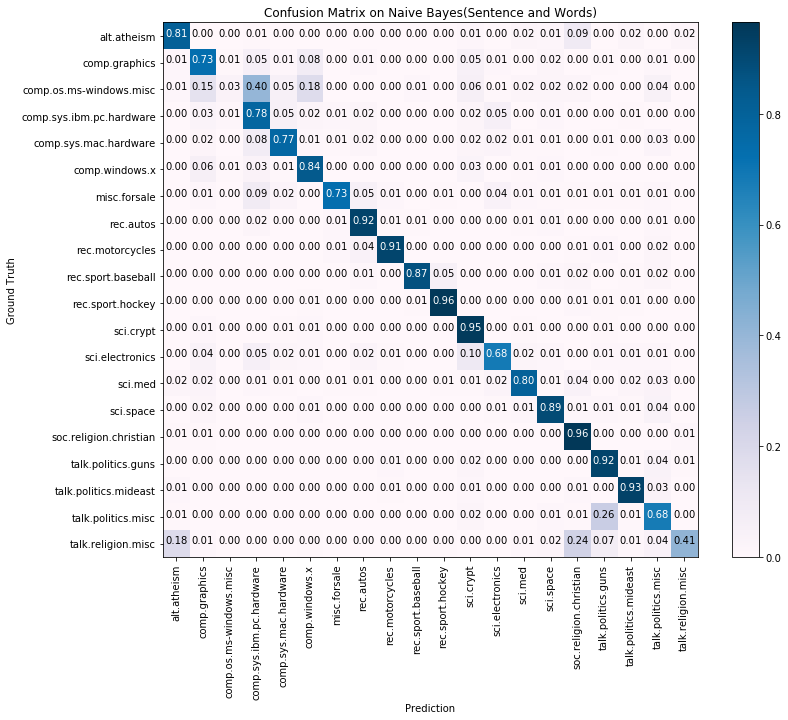

In [14]:
# Compute confusion matrix
cma = confusion_matrix(test_labels, prediction, labels=None, sample_weight=None)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 10), facecolor='w', edgecolor='b')
plot_confusion_matrix(cma, classes=newsgroups_test.target_names,
                      title='Confusion Matrix on Naive Bayes(Sentence and Words)')
plt.savefig('new_NB.png')